# Lane Fitting for the ONNX lane detection model output

/Users/atoch/workspace_priv/master-thesis/onnx-lanedetection-metadrive/pytorch_auto_drive/functional.py:101: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
2024-02-14 08:25:14.656835 [W:onnxruntime:, coreml_execution_provider.cc:81 GetCapability] CoreMLExecutionProvider::GetCapability, number of partitions supported by CoreML: 24 number of nodes in the graph: 326 number of nodes supported by CoreML: 299


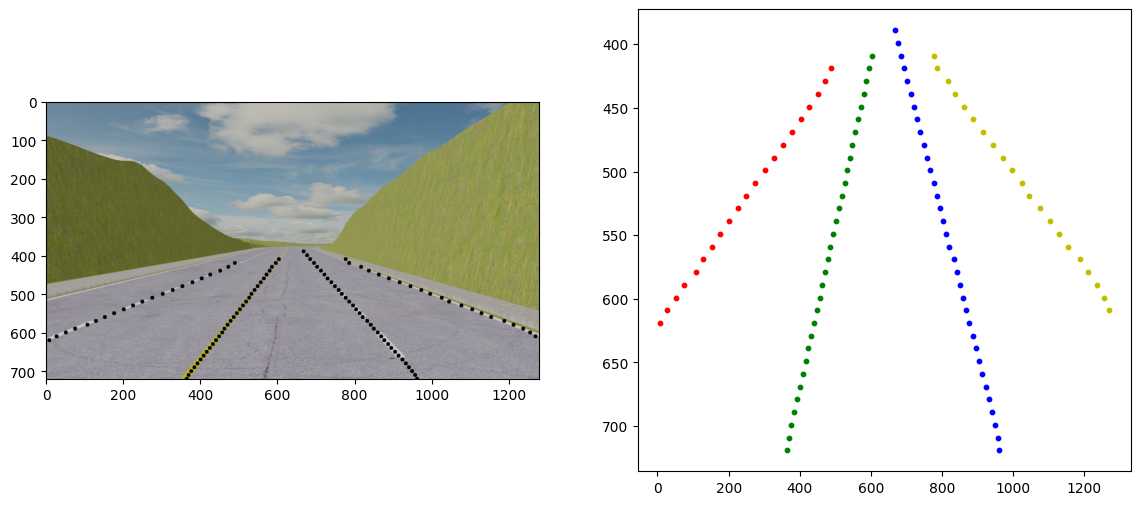

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import cv2
import numpy as np
from matplotlib import pyplot as plt
from inference_file import inference
import pytorch_auto_drive.functional as F

FILENAME = 'example_input.jpg'
# results, keypoints = inference(FILENAME, model_path='../../resnet50_resa_tusimple_20211019.onnx')
results, keypoints = inference(FILENAME, model_path='../../resnet50_resa_culane_20211016.onnx')

infered_img = results[0]
keypoints = keypoints[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.imshow(infered_img)
ax2.invert_yaxis()

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for i, lane in enumerate(keypoints):
    for point in lane:
        ax2.scatter(point[0], point[1], s=10, c=colors[i], marker='o')



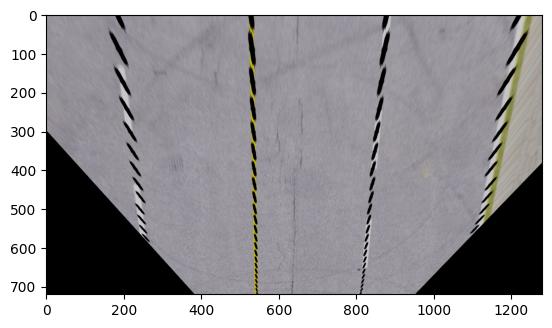

In [3]:
def getTransformMatrix(inpImage):
    # manually selected source and destination points
    src =  np.float32([[480, 500], [800, 500], [inpImage.shape[1]-50, inpImage.shape[0]],  [150, inpImage.shape[0]]])
    line_dst_offset = 300

    dst = np.float32([[src[3][0] + line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, 0], \
          [src[2][0] - line_dst_offset, src[2][1]], \
          [src[3][0] + line_dst_offset, src[3][1]]])

    matrix = cv2.getPerspectiveTransform(src, dst)
    minv = cv2.getPerspectiveTransform(dst, src)
    return matrix, minv

def perspectiveWarpImage(inpImage):
    matrix, matrix_inv = getTransformMatrix(inpImage)
   
    birdseye = cv2.warpPerspective(inpImage, matrix, inpImage.shape[0:2][::-1])

    # Get the birdseye window dimensions
    height, width = birdseye.shape[:2]

    # Divide the birdseye view into 2 halves to separate left & right lanes
    birdseyeLeft  = birdseye[0:height, 0:width // 2]
    birdseyeRight = birdseye[0:height, width // 2:width]

    # Display birdseye view image
    plt.imshow(birdseye)
    return birdseye

warped_image = perspectiveWarpImage(infered_img)

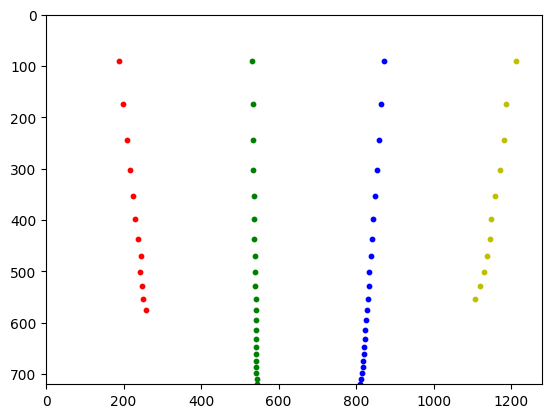

In [37]:
def transformPoint(point, matrix):
    # https://stackoverflow.com/a/57400980
    px = (matrix[0][0]*point[0] + matrix[0][1]*point[1] + matrix[0][2]) / ((matrix[2][0]*point[0] + matrix[2][1]*point[1] + matrix[2][2]))
    py = (matrix[1][0]*point[0] + matrix[1][1]*point[1] + matrix[1][2]) / ((matrix[2][0]*point[0] + matrix[2][1]*point[1] + matrix[2][2]))
    return (px, py)

def perspectiveWarp(keypoints, inpImage):

    colors = ['r', 'g', 'b', 'y', 'c', 'm']

    lanes=[]
    for i, lane in enumerate(keypoints): 
        matrix, matrix_inv = getTransformMatrix(inpImage)

        plt.ylim([0,inpImage.shape[0]])
        plt.xlim([0,inpImage.shape[1]])        
        plt.gca().invert_yaxis()

        result_points = []
        for point in lane:
            point = transformPoint(point, matrix)
            result_points.append(point)
            plt.scatter(point[0], point[1], s=10, c=colors[i], marker='o')

        
        lanes.append(np.float32(result_points))
        
    return lanes
        
plt.show()
lanes = perspectiveWarp(keypoints, infered_img)

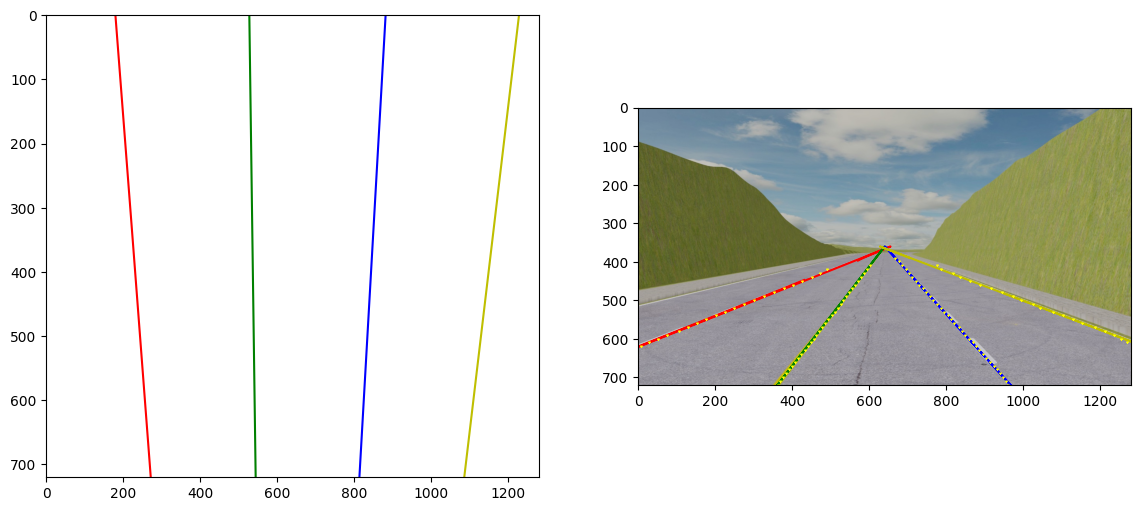

In [5]:
# Lane fitting

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.set_xlim([0,infered_img.shape[1]])
ax1.set_ylim([0,infered_img.shape[0]])
ax1.invert_yaxis()
colors = ['r', 'g', 'b', 'y', 'c', 'm']
matrix, matrix_inv = getTransformMatrix(infered_img)

lanes_transformed = []
polyonoms = []

for i, lane in enumerate(lanes): 
    polynom = np.polyfit(lane[:,0], lane[:,1], 2)
    predict = np.poly1d(polynom)
    polyonoms.append(predict)
    x_lin_reg = range(0, infered_img.shape[1])
    y_lin_reg = predict(x_lin_reg)
    ax1.invert_yaxis()
    ax1.plot(x_lin_reg, y_lin_reg, c = colors[i])

    lane_points_transformed=[[],[]]
    for point in x_lin_reg:
        point = (point, predict(point))
        px = (matrix_inv[0][0]*point[0] + matrix_inv[0][1]*point[1] + matrix_inv[0][2]) / ((matrix_inv[2][0]*point[0] + matrix_inv[2][1]*point[1] + matrix_inv[2][2]))
        py = (matrix_inv[1][0]*point[0] + matrix_inv[1][1]*point[1] + matrix_inv[1][2]) / ((matrix_inv[2][0]*point[0] + matrix_inv[2][1]*point[1] + matrix_inv[2][2]))
        p = (px, py)
        # TODO: check this limit
        if py > infered_img.shape[0] / 2:
            lane_points_transformed[0].append(px)  
            lane_points_transformed[1].append(py)
    # plt.scatter(lane_points_transformed[0], lane_points_transformed[1], s=10, c=colors[i], marker='o')
    lanes_transformed.append(lane_points_transformed)

from PIL import Image
# overlay the original image
original_img = Image.open(FILENAME)
for i, lane in enumerate(lanes_transformed):
    ax2.plot(lane[0], lane[1], c = colors[i], zorder=1)
# ax2.fill_betweenx(lanes_transformed[1][1], lanes_transformed[1][0], lanes_transformed[2][0])
# print initial keypoints
for lane in keypoints:
    for point in lane:
        ax2.scatter(point[0], point[1], marker="2", color="yellow", s=2, zorder=2)
ax2.imshow(original_img)




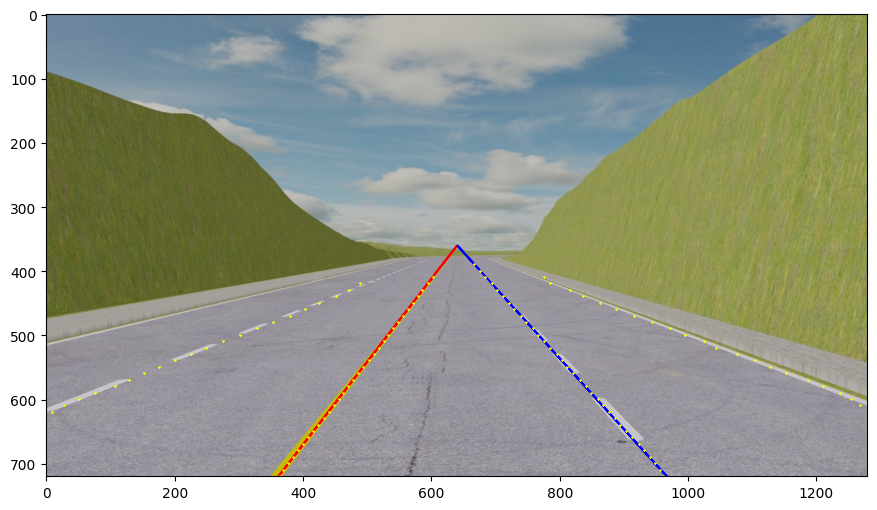

In [38]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))


left_lane = np.float32(lanes_transformed[0])
right_lane = np.float32(lanes_transformed[len(lanes_transformed)-1])
selected_indices = [0, len(lanes_transformed)-1]
middle = original_img.size[0]/2

for i, lane in enumerate(lanes_transformed):
    avg = np.average(lane[0])

    if avg < middle and avg > np.average(left_lane[0]):
        left_lane = np.float32(lane)
        selected_indices[0] = i
        continue

    if avg > middle and avg < np.average(right_lane[0]):
        right_lane = np.float32(lane)
        selected_indices[1] = i
        continue

    
left_lane = left_lane.T
left_lane = np.vstack(left_lane[left_lane[:, 0] <= middle, :]).T
left_lane_poly = polyonoms[selected_indices[0]]

right_lane = right_lane.T
right_lane = np.vstack(right_lane[right_lane[:, 0] >= middle, :]).T
right_lane_poly = polyonoms[selected_indices[1]]

ax1.plot(left_lane[0], left_lane[1], c = 'red', zorder=1)
ax1.plot(right_lane[0], right_lane[1], c = 'blue', zorder=1)

for lane in keypoints:
    for point in lane:
        ax1.scatter(point[0], point[1], marker="2", color="yellow", s=2, zorder=2)
ax1.imshow(original_img)

(664.1884850769883, 720.0)
Angle: -2.671430812771592 degrees
Curve Direction: Left Curve
Lane Width: 3.5016440994458873 m
Off Center: 0.0041 m


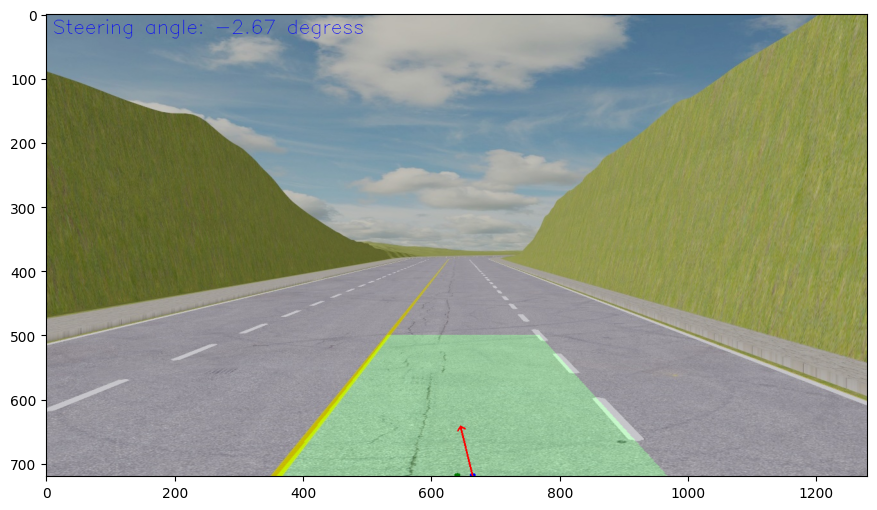

In [68]:
fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))
# ax1.set_xlim([0,infered_img.shape[1]])
# ax1.set_ylim([0,infered_img.shape[0]])
# ax1.invert_yaxis()

def calculate_radius(image, left_lane_poly, right_lane_poly):
    height = image.height
    width = image.width

    # zeroed_channel = np.zeros_like((height,width)).astype(np.uint8)
    # color_fill_image = np.dstack((zeroed_channel, zeroed_channel, zeroed_channel))
    color_fill_image = np.zeros([height, width, 3])

    plot_x = np.linspace(0, width - 1, width)
    left_fit_y = left_lane_poly(plot_x)
    right_fit_y = right_lane_poly(plot_x)
    
    l1 = np.transpose(np.vstack([plot_x, left_fit_y]))
    l2 = np.array(np.transpose(np.vstack([plot_x, right_fit_y])))
    pts = np.int_(np.vstack((l1, l2)))

    color_fill_image = cv2.fillPoly(color_fill_image, [pts], (0, 255, 0))  

    image_np = np.array(image)

    matrix, matrix_inv = getTransformMatrix(image_np)   
    color_fill_image_transformed = cv2.warpPerspective(color_fill_image, matrix_inv, (width, height))
    result = cv2.addWeighted(image_np, 1, color_fill_image_transformed, 0.2, 0, dtype=cv2.CV_8U)


    ### Angle calculation ###

    ym_per_pix = 0.000106  # meters per pixel in y dimension
    xm_per_pix = 0.000106  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(plot_x * xm_per_pix, left_fit_y * ym_per_pix, 2)
    right_fit_cr = np.polyfit(plot_x * xm_per_pix, right_fit_y * ym_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * height * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])

    right_curverad = (
                         (1 + (2 * right_fit_cr[0] * height * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    radius1 = round((float(left_curverad) + float(right_curverad))/2.,2)
    
    if left_lane_poly.coefficients[0] - left_lane_poly.coefficients[-1] > 60:
        curve_direction = 'Left Curve'
        radius=-5729.57795/radius1
    elif left_lane_poly.coefficients[-1] - left_lane_poly.coefficients[0] > 60:
        curve_direction = 'Right Curve'
        radius=5729.57795/radius1
    else:
        curve_direction = 'Straight'
        radius=5729.57795/radius1

    lane_width = (right_lane_poly.coefficients[2] - left_lane_poly.coefficients[2]) * xm_per_pix
    center = (right_lane_poly(0) - left_lane_poly(0)) / 2
    

    left_lane_start =np.min(np.poly1d(left_lane_poly-height).r)
    right_lane_start = np.max(np.poly1d(right_lane_poly-height).r)
    center_x = left_lane_start + (right_lane_start - left_lane_start) / 2
    center_world = transformPoint((center_x, height), matrix_inv)

    off_center = round((center_x - width / 2.) * xm_per_pix,4) # assume camera is in the center of the car

    # draw a point for the center at y=0

    cv2.circle(result, np.int_(center_world), 5, (0, 0, 255), -1) # current center
    cv2.circle(result, np.int_((width/2, height)), 5, (0, 120, 0), -1) # desired center
    
    angle_rad = np.radians(radius-90)
    end_point = transformPoint((center_x + 100 * np.cos(angle_rad), height + 100 * np.sin(angle_rad)), matrix_inv)
    cv2.arrowedLine(result, np.int_(center_world), np.int_(end_point), (255, 0, 0), 2)  
    cv2.putText(result, f'Steering angle: {radius:.2f} degress', (10, 30), cv2.FONT_HERSHEY_SIMPLEX , 1, (0, 0, 255))


    print('Angle:', radius, 'degrees')
    print('Curve Direction:', curve_direction)
    print('Lane Width:', lane_width, 'm') # should match BaseMap.LANE_WIDTH: 3.5
    print('Off Center:', off_center, 'm')

    ax1.imshow(result)

calculate_radius(original_img, left_lane_poly, right_lane_poly)